# Geometryczne - lab 2 - ćwiczenie 2

1. Przygotuj program generujący następujące zbiory punktów na płaszczyźnie
(współrzędne rzeczywiste typu double):
a) zawierający 100 losowo wygenerowanych punktów o współrzędnych z przedziału
[-100, 100],
b) zawierający 100 losowo wygenerowanych punktów leżących na okręgu o środku
(0,0) i promieniu R=10,
c) zawierający 100 losowo wygenerowanych punktów leżących na bokach prostokąta
o wierzchołkach (-10, 10), (-10,-10), (10,-10), (10,10),
d) zawierający wierzchołki kwadratu (0, 0), (10, 0), (10, 10), (0, 10) oraz punkty
wygenerowane losowo w sposób następujący: po 25 punktów na dwóch bokach
kwadratu leżących na osiach i po 20 punktów na przekątnych kwadratu.

2. Uruchom wizualizację graficzną utworzonych zbiorów punktów.

3. Zmodyfikuj program z punktu 1 tak, aby możliwe było zadawanie określonych
parametrów dla schematów losowania punktów podanych powyżej:
a) liczba punktów, przedziały dla współrzędnych,
b) liczba punktów, środek i promień okręgu,
c) liczba punktów, wierzchołki prostokąta,
d) wierzchołki kwadratu, liczba punktów na osiach, liczba punktów na przekątnych.

4. Zaimplementuj algorytmy Grahama oraz Jarvisa wyznaczające otoczkę wypukłą dla
zadanego zbioru punktów. Przetestuj program na zbiorach z punktu 1 oraz
zmodyfikowanych zbiorach z punktu 3. Program powinien pozwolić na zapisanie w
pliku wyniku działania, czyli ciągu wierzchołków otoczki. Dodaj możliwość
sprawdzenia czasu działania algorytmu.

Uruchom aplikację graficzną tak, aby można było zilustrować graficznie poszczególne
kroki realizacji algorytmu. Jednym kolorem powinny być zaznaczone wszystkie punkty
zbioru wyjściowego, drugim kolorem boki aktualnie rozpatrywane, a trzecim boki
wielokąta otoczki. Po zakończeniu wyznaczania otoczki wierzchołki otoczki powinny
być wyróżnione (osobnym kolorem bądź kształtem).

5. W sprawozdaniu napisz, czy Twój program działał poprawnie dla wszystkich zbiorów
danych oraz opisz krótko wnioski dotyczące działania algorytmu dla poszczególnych
zbiorów. Napisz, dlaczego wg Ciebie zaproponowano takie zbiory punktów? Które ze
zbiorów mogły stwarzać problemy w działaniu algorytmów? Jeśli tak, to jakie i
dlaczego? Porównaj czasy działania obu algorytmów w zależności od liczby punktów
w poszczególnych zbiorach (a, b, c, d). Dołącz wybrane, istotne ilustracje.

### Narzędzie geometryczne

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()


# Własne rozszerzenie narzędzia geometrycznego
class BetterPlot:
    def __init__(self):
        self.clear()

    def clear(self):
        self.scenes = []
        self.points = []
        self.lines = []
        return self

    def add_pts(self, *pts, c='black', s=.5):
        self.points.append(PointsCollection(pts, color=c, s=s))
        return self

    def add_lines(self, *fr_to, c='black', w=.5):
        self.lines.append(LinesCollection(fr_to, color=c, linewidth=w))
        return self

    def add_polygon(self, pts, close=True, draw_pts=True, c='black', c_p='black', w=.5, s=.5):
        self.add_lines(*[ [pts[i], pts[i-1]] for i in range(0 if close else 1, len(pts)) ], c=c, w=w)
        if draw_pts:
            self.add_pts(*pts, c=c_p, s=s)
        return self

    def add_scene(self, pts=None, lines=None):
        pts = [] if pts is None else pts
        lines = [] if lines is None else lines
        self.scenes.append(Scene(pts.copy(), lines.copy()))
        return self

    def save_scene_cls(self):
        self.scenes.append(Scene(self.points.copy(), self.lines.copy()))
        self.points = []
        self.lines = []
        return self

    def set_limits(self, xlim, ylim=None):
        ylim = xlim if ylim is None else ylim
        self.add_pts((xlim[0], ylim[0]), (xlim[1], ylim[1]), c='white', s=0)
        return self

    def set_uniform_scale(self, curr_xlim, curr_ylim):
        x_mid = (curr_xlim[1] + curr_xlim[0]) / 2
        x_span = curr_xlim[1] - x_mid
        y_mid = (curr_ylim[1] + curr_ylim[0]) / 2
        y_span = curr_ylim[1] - y_mid
        if y_span > x_span*1.5:
            x_span = y_span
        else:
            y_span = x_span
        self.add_pts((x_mid-x_span*1.5, y_mid-y_span), (x_mid+x_span*1.5, y_mid+y_span), c='white', s=0)
        return self

    def get_plot(self):
        if self.scenes:
            p = Plot(scenes=self.scenes)
        else:
            p = Plot(points=self.points, lines=self.lines)
        return p

## Generowanie punktów

In [2]:
import numpy as np


def gen_points():
    points_a = [ (np.random.uniform(-100, 100), np.random.uniform(-100, 100)) for _ in range(100) ]
    
    points_b = []
    for _ in range(100):
        t = np.random.uniform(-1, 1)
        points_b.append( (np.cos(np.pi*t)*10, np.sin(np.pi*t)*10) )

    points_c = []
    rect = [(-10, -10), (10, 10)]
    side_lengths = [rect[1][i] - rect[0][i] for i in range(2)]
    for _ in range(100):
        side = np.random.randint(4)
        ax = side % 2
        if side < 2:
            corner = rect[0]
            t = np.random.uniform(corner[ax], corner[ax] + side_lengths[ax])
        else:
            corner = rect[1]
            t = np.random.uniform(corner[ax] - side_lengths[ax], corner[ax])
        points_c.append((t, corner[1-ax]) if ax == 0 else (corner[1-ax], t))

    points_d = [(0, 0), (10, 0), (10, 10), (0, 10)]
    for side in range(2):
        for _ in range(25):
            t = np.random.uniform(0, 10)
            points_d.append((0, t) if side == 0 else (t, 0))
    for diagonal in range(2):
        for _ in range(20):
            t = np.random.uniform(0, 10)
            points_d.append((t, t) if diagonal == 0 else (t, 10-t))

    return points_a, points_b, points_c, points_d

pts_a, pts_b, pts_c, pts_d = gen_points()

## Wizualizacja zbiorów punktów

In [3]:
# Konfiguracja początkowa
%matplotlib widget
b = BetterPlot()

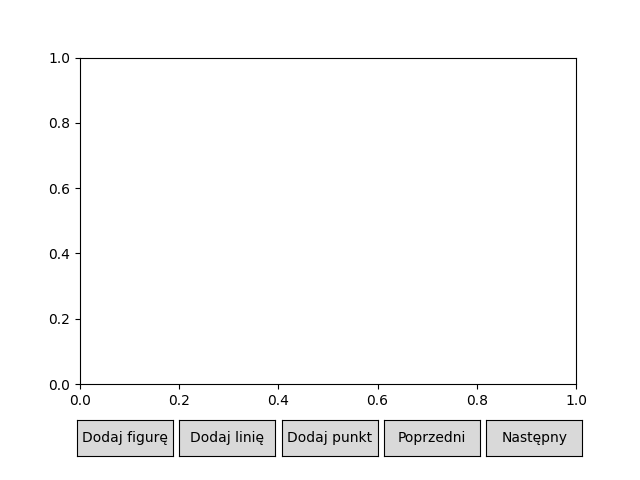

In [4]:
# Zbiór A
p = b.clear().add_pts(*pts_a, s=4).set_uniform_scale((-100, 100), (-100, 100)).get_plot()
p.draw()

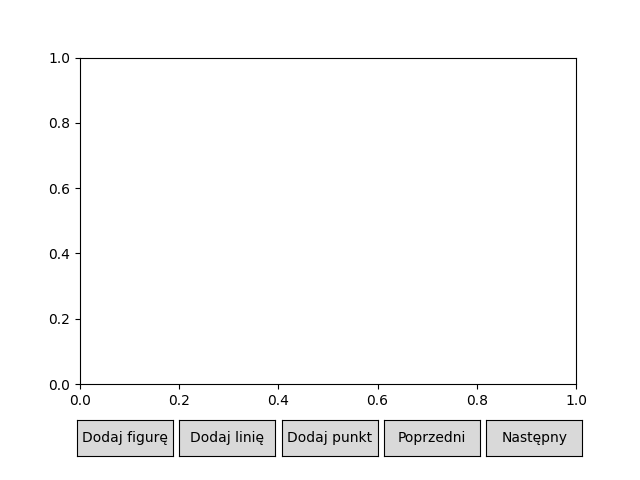

In [5]:
# Zbiór B
p = b.clear().add_pts(*pts_b, s=4).set_uniform_scale((-10, 10), (-10, 10)).get_plot()
p.draw()

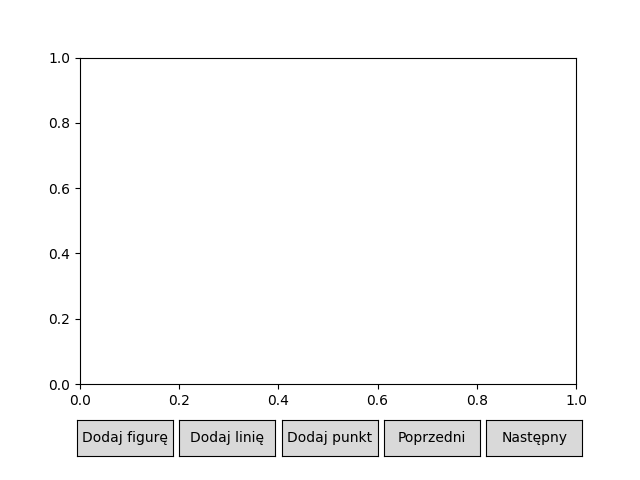

In [6]:
# Zbiór C
p = b.clear().add_pts(*pts_c, s=4).set_uniform_scale((-10, 10), (-10, 10)).get_plot()
p.draw()

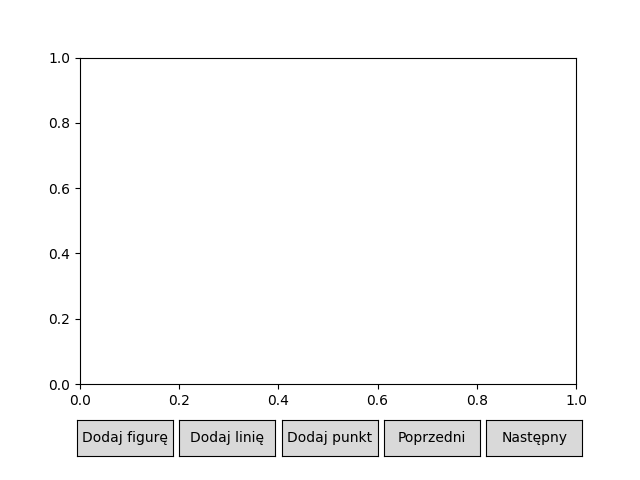

In [7]:
# Zbiór D
p = b.clear().add_pts(*pts_d, s=4).set_uniform_scale((0, 10), (0, 10)).get_plot()
p.draw()

## Parametryzacja generowania punktów

In [4]:
def parametrised_gen_points(scheme, range_min=0, range_max=0, amount=0, centre=(0, 0), radius=0,
                            rect_lowerleft=(0, 0), rect_upperright=(0, 0), sq_lowerleft=(0, 0),
                            sq_upperright=(0, 0), amount_side=0, amount_diagonal=0):
    if scheme == 'a':
        return [ (np.random.uniform(range_min, range_max), np.random.uniform(range_min, range_max))
                 for _ in range(amount) ]

    if scheme == 'b':
        pts = []
        for _ in range(amount):
            t = np.random.uniform(-1, 1)
            pts.append( (centre[0]+np.cos(np.pi*t)*radius, centre[1]+np.sin(np.pi*t)*radius) )
        return pts

    if scheme == 'c':
        pts = []
        rect = [rect_lowerleft, rect_upperright]
        side_lengths = [rect[1][i] - rect[0][i] for i in range(2)]
        for _ in range(amount):
            side = np.random.randint(4)
            ax = side % 2
            if side < 2:
                corner = rect[0]
                t = np.random.uniform(corner[ax], corner[ax] + side_lengths[ax])
            else:
                corner = rect[1]
                t = np.random.uniform(corner[ax] - side_lengths[ax], corner[ax])
            pts.append((t, corner[1-ax]) if ax == 0 else (corner[1-ax], t))
        return pts

    if scheme == 'd':
        pts = [sq_lowerleft, (sq_lowerleft[0], sq_upperright[1]), (sq_upperright[0], sq_lowerleft[1]), sq_upperright]
        side_len = sq_upperright[0] - sq_lowerleft[0]
        for side in range(2):
            for _ in range(amount_side):
                if side == 0:
                    t = np.random.uniform(sq_lowerleft[1], sq_upperright[1])
                    pts.append((sq_lowerleft[0], t))
                else:
                    t = np.random.uniform(sq_lowerleft[0], sq_upperright[0])
                    pts.append((t, sq_lowerleft[1]))
        for diagonal in range(2):
            for _ in range(amount_diagonal):
                t = np.random.uniform(0, side_len)
                pts.append((sq_lowerleft[0]+t, sq_lowerleft[1]+t) if diagonal == 0 else (sq_lowerleft[0]+t, sq_upperright[1]-t))
        return pts

    return []

In [5]:
def gen_bulk_test_data():
    dt = {'a': {'regular': pts_a.copy()}, 'b': {'regular': pts_b.copy()},
          'c': {'regular': pts_c.copy()}, 'd': {'regular': pts_d.copy()}}
    for scheme in ('a', 'b', 'c', 'd'):
        for amount in (100, 1000, 10000, 100000):
            dt[scheme][str(amount)] = parametrised_gen_points(scheme,
                amount=amount, amount_side=amount//4, amount_diagonal=amount//5,  # amounts
                range_min=-10**14, range_max=10**14,                              # scheme 'a'
                centre=(-5000, -10000), radius=10000,                             # scheme 'b'
                rect_lowerleft=(-5000, -10000), rect_upperright=(5000, 20000),    # scheme 'c'
                sq_lowerleft=(50000, 0), sq_upperright=(60000, 10000))            # scheme 'd'
    return dt

In [6]:
# Generowanie testowego słownika
test_data = gen_bulk_test_data()

## Wizualizacja sparametryzowanych zbiorów

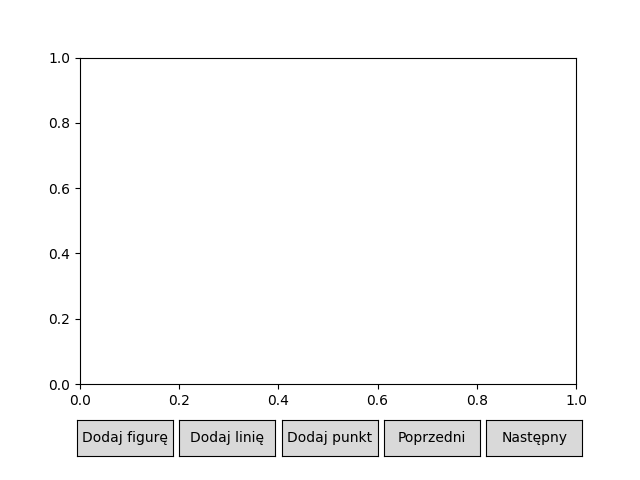

In [11]:
# Nowy A, 10000 punktów
p = b.clear().add_pts(*test_data['a']['10000']).set_uniform_scale((-10**14, 10**14), (-10**14, 10**14)).get_plot()
p.draw()

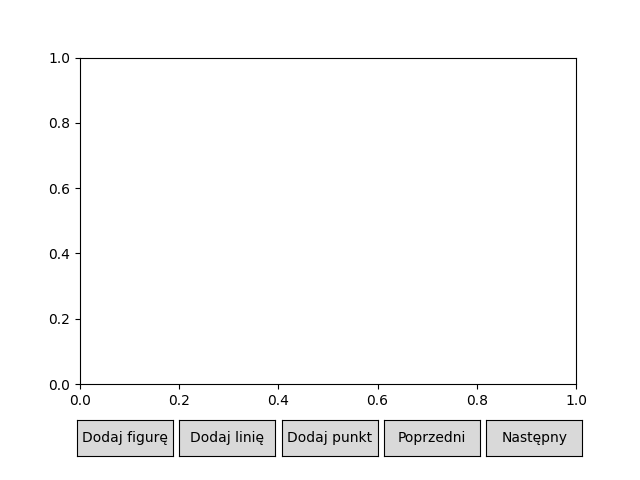

In [12]:
# Nowy B, 1000 punktów
p = b.clear().add_pts(*test_data['b']['1000']).set_uniform_scale((-15000, 5000), (-20000, 0)).get_plot()
p.draw()

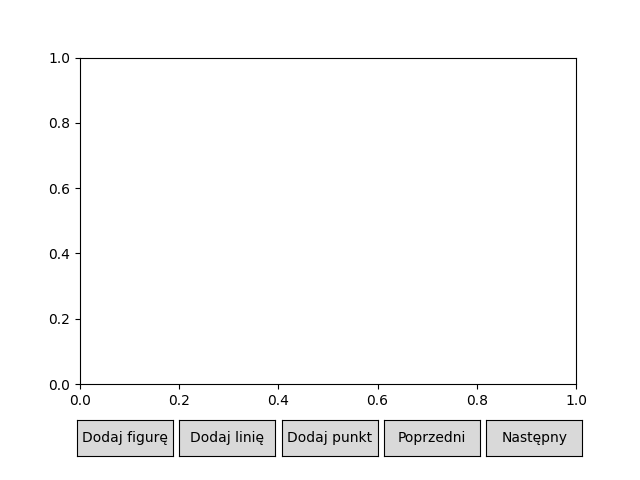

In [13]:
# Nowy C, 1000 punktów
p = b.clear().add_pts(*test_data['c']['1000']).set_uniform_scale((-5000, 5000), (-10000, 20000)).get_plot()
p.draw()

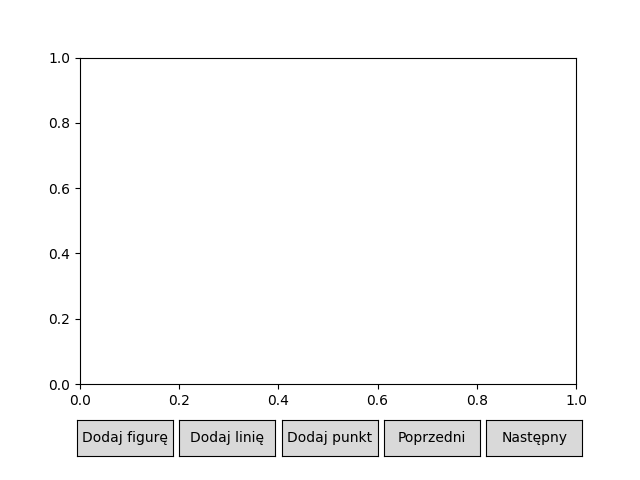

In [14]:
# Nowy D, 1000 punktów
p = b.clear().add_pts(*test_data['d']['1000']).set_uniform_scale((50000, 60000), (0, 10000)).get_plot()
p.draw()

## Implementacja algorytmów

### Algorytmy

In [36]:
import math
from collections import deque
from functools import cmp_to_key


#################### WYZNACZNIK ####################
def det_3x3(a, b, c):
    ax, ay = a
    bx, by = b
    cx, cy = c
    return np.float64(math.fsum([ax*by, bx*cy, cx*ay, -cx*by, -ax*cy, -bx*ay]))


###################### GRAHAM ######################
def ch_graham(pts, eps=10**(-12), drawing_data=None):
    # KOMPARATOR
    cmp = lambda b, c: -det_3x3(p_0, b, c)

    p_0 = min(pts, key=lambda p: (p[1], p[0]))
    sorted_pts = sorted([pt for pt in pts if pt != p_0], key=cmp_to_key(cmp))
    N = len(sorted_pts)

    consider = [True for _ in sorted_pts]
    prev_i = 0
    for i in range(1, N):
        pt = sorted_pts[i]
        prev_pt = sorted_pts[prev_i]
        if abs(det_3x3(p_0, pt, prev_pt)) < eps:
            if pt[1] > prev_pt[1] or (pt[1] == prev_pt[1] and pt[0] > prev_pt[0]):
                consider[prev_i] = False
                prev_i = i
            else:
                consider[i] = False
        else:
            prev_i = i
    print(f'po eliminacji: {sum((1 if c else 0 for c in consider))}')

    s = deque([p_0])
    i = 0
    while len(s) < 3:
        if consider[i]:
            s.append(sorted_pts[i])
        i += 1

    while i < N:
        if not consider[i]:
            i += 1
            continue

        if drawing_data is not None:
            drawing_data.append({'ch_pts': list(s), 'curr_pt': sorted_pts[i]})

        if det_3x3(s[-2], s[-1], sorted_pts[i]) > eps:
            s.append(sorted_pts[i])
            i += 1
        else:
            s.pop()

    return list(s)


###################### JARVIS ######################
def ch_jarvis(pts, eps=10**(-12), drawing_data=None):
    N = len(pts)
    p_0 = min(pts, key=lambda p: (p[1], p[0]))
    i_0 = pts.index(p_0)

    dist = lambda a, b: math.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)

    ch = [p_0]
    i = None
    while i != i_0:
        if i is None:
            i = i_0
        k = None
        for j in range(N):
            if i == j:
                continue
            if k is None:
                k = j
                continue
            det = det_3x3(pts[i], pts[k], pts[j])
            if det < -eps:
                k = j
            elif det < eps and dist(pts[i], pts[j]) > dist(pts[i], pts[k]):
                k = j

        if drawing_data is not None:
            drawing_data.append({'ch_pts': ch.copy(), 'curr_pt': pts[k]})

        if k != i_0:
            ch.append(pts[k])
        i = k

    return ch

### Wrapper na wywołania powyższych funkcji

In [8]:
import multiprocessing
from time import perf_counter


def ch_wrapper(pts, ch_fun, time=False, save=False, save_as=None,
               eps=10**(-12), drawing_data=None, time_limit=60):

    def ch_fun_wrapper(ch_fun, q, *args, **kwargs):
        t_s = perf_counter()
        res = ch_fun(*args, **kwargs)
        t_e = perf_counter()
        q.put((res, t_e-t_s))


    q = multiprocessing.Queue()
    p = multiprocessing.Process(target=ch_fun_wrapper, name='convex_hull_calc',
                                args=(ch_fun, q, pts, eps, drawing_data))
    p.start()
    p.join(time_limit)
    if p.is_alive():
        p.terminate()
        print('Time limit exceeded!')
        p.join()
        return []
    ch, tm = q.get()

    if time:
        print(f'Time: {tm} s')

    if save:
        with open(save_as if save_as is not None else 'ch_data.txt', 'w') as f:
            for pt in ch:
                f.write(f'{pt}\n')

    return ch

In [9]:
# Przykładowe wywołanie funkcji
ch = ch_wrapper(test_data['b']['regular'].copy(), ch_graham, time=True, eps=10**(-12), time_limit=120, save=True, save_as='out.txt')
print(len(ch))

Time: 0.002737549000130457 s
100


### Obliczanie wyników dla wszystkich zbiorów

In [10]:
# Globalne ustawienie zapisywania wyników do pliku
SAVE_RESULTS=False

# Globalne ustawienie limitu czasu pojedynczego wywołania (w sekundach)
TIME_LIMIT=120

possible_eps = (10**(-6), 10**(-12))

results = {}
for p_set, td in test_data.items():
    results[p_set] = {}
    print(f'POINTS SET {p_set}')
    for eps in possible_eps:
        results[p_set][eps] = {}
        print(f'  {eps=}')
        for n, pts in td.items():
            results[p_set][eps][n] = {}
            p = pts.copy()
            np.random.shuffle(p)
            print(f'    {n=}\n        GRAHAM ', end='')
            g = ch_wrapper(p, ch_graham, time=True, save=SAVE_RESULTS, save_as=f'ch_data_{p_set}_{eps}_{n}_graham.txt', time_limit=TIME_LIMIT, eps=eps)
            results[p_set][eps][n]['graham'] = g
            print(f'               {len(g)} points\n        JARVIS ', end='')
            g = ch_wrapper(p, ch_jarvis, time=True, save=SAVE_RESULTS, save_as=f'ch_data_{p_set}_{eps}_{n}_jarvis.txt', time_limit=TIME_LIMIT, eps=eps)
            results[p_set][eps][n]['jarvis'] = g
            print(f'               {len(g)} points')

POINTS SET a
  eps=1e-06
    n='regular'
        GRAHAM Time: 0.0028158290000419584 s
               9 points
        JARVIS Time: 0.002325430999917444 s
               9 points
    n='100'
        GRAHAM Time: 0.00463847599996825 s
               12 points
        JARVIS Time: 0.003245162999974127 s
               12 points
    n='1000'
        GRAHAM Time: 0.0347867650000353 s
               17 points
        JARVIS Time: 0.04453586199997517 s
               17 points
    n='10000'
        GRAHAM Time: 0.32496280899999874 s
               29 points
        JARVIS Time: 0.4660260099999505 s
               29 points
    n='100000'
        GRAHAM Time: 3.3096198109999477 s
               23 points
        JARVIS Time: 4.157728858000041 s
               23 points
  eps=1e-12
    n='regular'
        GRAHAM Time: 0.0023384149999401416 s
               9 points
        JARVIS Time: 0.002002102999995259 s
               9 points
    n='100'
        GRAHAM Time: 0.0017837689999851136 s
      

## Wizualizacja kroków wykonania algorytmu
Schemat kolorystyczny jest opisany w sprawozdaniu.

Aby sprawdzić same efekty, proszę kliknąć "Poprzedni".

### Funkcja pomocnicza

In [10]:
def get_step_plot(pts, ch_fun, eps=10**(-12), xlim=None, ylim=None):
    p_list = pts.copy()
    drawing_data = []
    ch = ch_fun(p_list, drawing_data=drawing_data, eps=eps)

    b = BetterPlot()
    b.clear()
    for step in drawing_data:
        b.add_pts(*p_list, s=10, c='black')
        b.add_polygon(step['ch_pts'], close=False, draw_pts=False, c='green', w=2)
        b.add_lines((step['ch_pts'][-1], step['curr_pt']), c='red', w=2)
        if xlim is not None:
            b.set_uniform_scale(xlim, ylim)
        b.save_scene_cls()
    b.add_polygon(ch, c='royalblue', w=2, c_p='cyan', s=50)
    b.add_pts(*[p for p in p_list if p not in ch], s=10, c='black')
    if xlim is not None:
        b.set_uniform_scale(xlim, ylim)
    b.save_scene_cls()
    return b.get_plot()

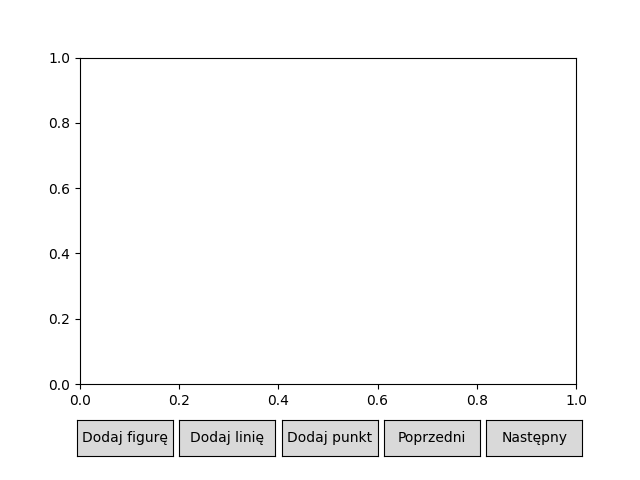

In [12]:
# Graham na zbiorze A
p = get_step_plot(test_data['a']['regular'], ch_graham, 10**(-12), (-100, 100), (-100, 100))
p.draw()

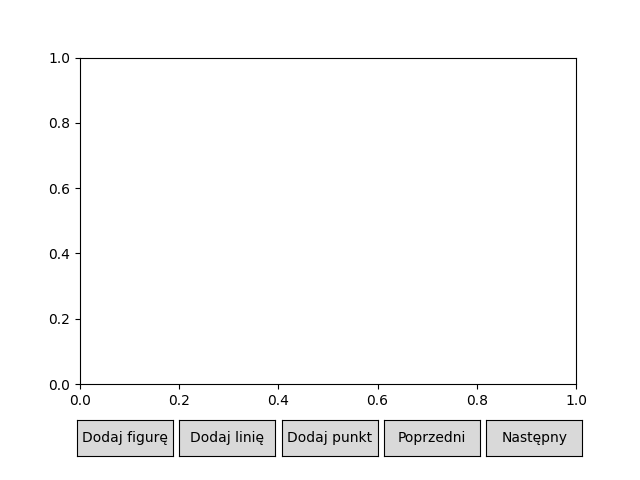

In [36]:
# Jarvis na zbiorze A
p = get_step_plot(test_data['a']['regular'], ch_jarvis, 10**(-12), (-100, 100), (-100, 100))
p.draw()

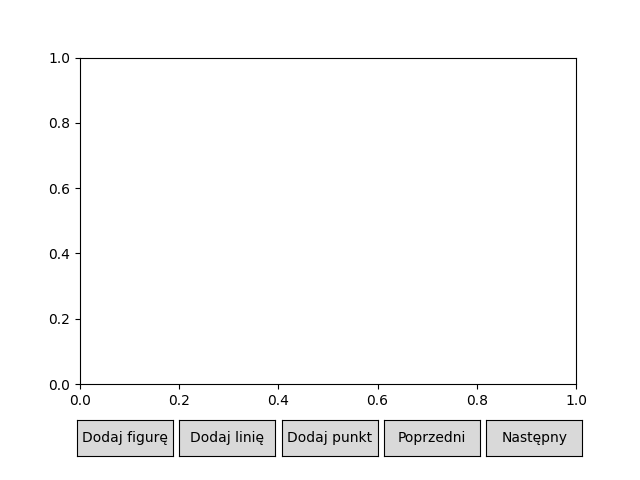

In [28]:
# Graham na zbiorze B
p = get_step_plot(test_data['b']['regular'], ch_graham, 10**(-12), (-10, 10), (-10, 10))
p.draw()

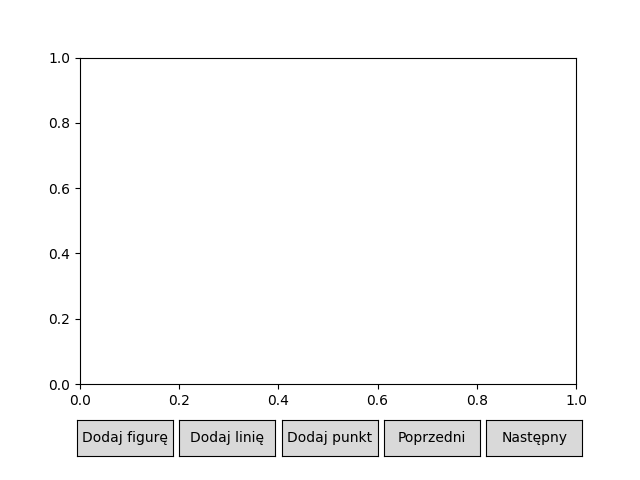

In [29]:
# Jarvis na zbiorze B
p = get_step_plot(test_data['b']['regular'], ch_jarvis, 10**(-12), (-10, 10), (-10, 10))
p.draw()

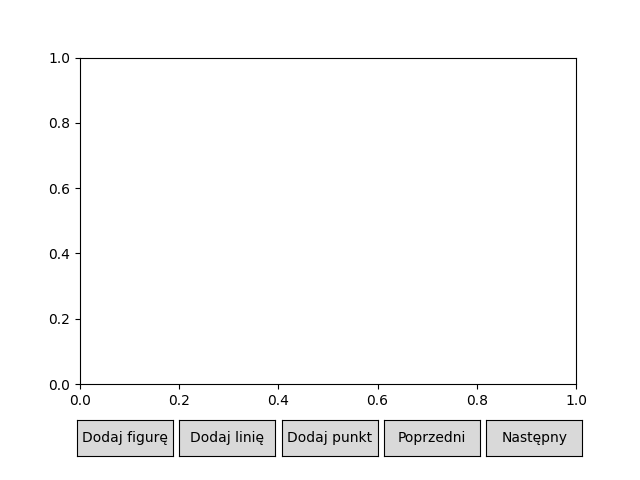

In [30]:
# Graham na zbiorze C
p = get_step_plot(test_data['c']['regular'], ch_graham, 10**(-12), (-10, 10), (-10, 10))
p.draw()

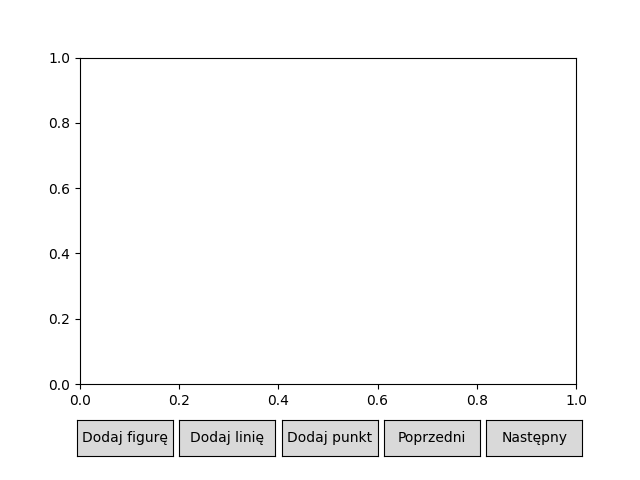

In [31]:
# Jarvis na zbiorze C
p = get_step_plot(test_data['c']['regular'], ch_jarvis, 10**(-12), (-10, 10), (-10, 10))
p.draw()

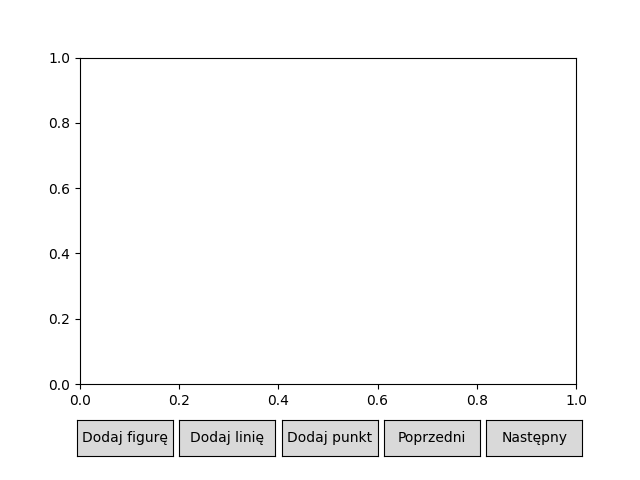

In [13]:
# Graham na zbiorze D
p = get_step_plot(test_data['d']['regular'], ch_graham, 10**(-12), (0, 10), (0, 10))
p.draw()

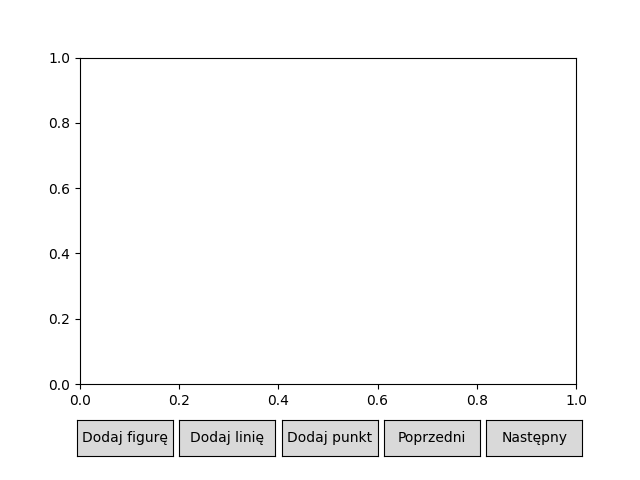

In [16]:
# Jarvis na zbiorze D
p = get_step_plot(test_data['d']['regular'], ch_jarvis, 10**(-12), (0, 10), (0, 10))
p.draw()

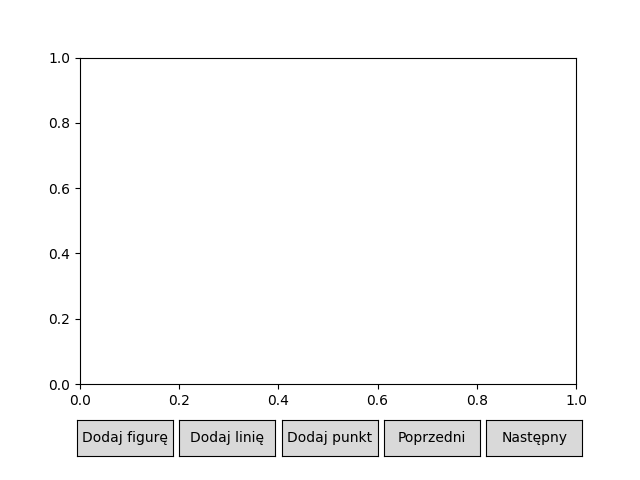

In [26]:
# jakieś testy co mogło pójść nie tak
n = 10000
pts = parametrised_gen_points('d', sq_lowerleft=(0, 0), sq_upperright=(10, 10), amount_diagonal=n//4, amount_side=n//5)
p = b.clear().add_pts(*pts).get_plot()
p.draw()

In [37]:
ch = ch_wrapper(pts, ch_graham)
print(len(ch))

po eliminacji: 2503
4


In [38]:
pts_moved = [(x+50000, y) for x, y in pts]
ch = ch_wrapper(pts_moved, ch_graham)
print(len(ch))

po eliminacji: 3787
870


In [39]:
pts_wide = parametrised_gen_points('d', sq_lowerleft=(0, 0), sq_upperright=(10000, 10000), amount_diagonal=n//4, amount_side=n//5)

In [40]:
print(len(ch_wrapper(pts_wide, ch_graham)))

po eliminacji: 2503
4


In [41]:
pts_wide_moved = [(x+50000, y) for x, y in pts]
print(len(ch_wrapper(pts_wide_moved, ch_graham)))

po eliminacji: 3787
870


In [42]:
pts_wide_inplace = parametrised_gen_points('d', sq_lowerleft=(50000, 0), sq_upperright=(60000, 10000), amount_diagonal=n//4, amount_side=n//5)

In [43]:
print(len(ch_wrapper(pts_wide_inplace, ch_graham)))

po eliminacji: 3883
944
